In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import pulse2percept as p2p

2017-03-31 15:26:33,952 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
implant = p2p.implants.ElectrodeArray('epiretinal', 260, 0, 0, hs=0)

In [3]:
sim = p2p.Simulation(implant)

In [4]:
sim.set_optic_fiber_layer(sampling=100, x_range=0, y_range=0)

In [5]:
tsample = 5e-6
sim.set_ganglion_cell_layer(tsample=tsample)

In [6]:
amps = np.linspace(0, 100, 21, endpoint=True)
freqs = np.linspace(0, 200, 21, endpoint=True)
ecs = np.linspace(0, 1.5, 16, endpoint=True)

In [7]:
in_list = []
for a in amps:
    for f in freqs:
        for e in ecs:
            in_list.append([a, f, e])
len(in_list)

7056

In [8]:
def get_pulse_train(freq, amp, tsample):
    return p2p.stimuli.PulseTrain(tsample, freq=freq, amp=amp,
                                  pulse_dur=0.45 / 1000, interphase_dur=0.45 / 1000,
                                  delay=0, pulsetype='cathodicfirst')

In [9]:
def run_pixel(params, gcl):
    a, f, e = params
    pt = get_pulse_train(f, a, gcl.tsample)
    ecm = [0, e * pt.data]
    out = gcl.model_cascade(ecm, ['GCL'], dojit=True)
    return out.data.max()

In [10]:
out_list = p2p.utils.parfor(run_pixel, in_list, func_args=[sim.gcl], engine='joblib')

In [11]:
pickle.dump((in_list, out_list), open('temporal-model-amps-freqs-ecs.dat', 'wb'))

In [12]:
in_list, out_list = pickle.load(open('temporal-model-amps-freqs-ecs.dat', 'rb'))

In [13]:
in_arr = np.array(in_list)
out_arr = np.array(out_list)

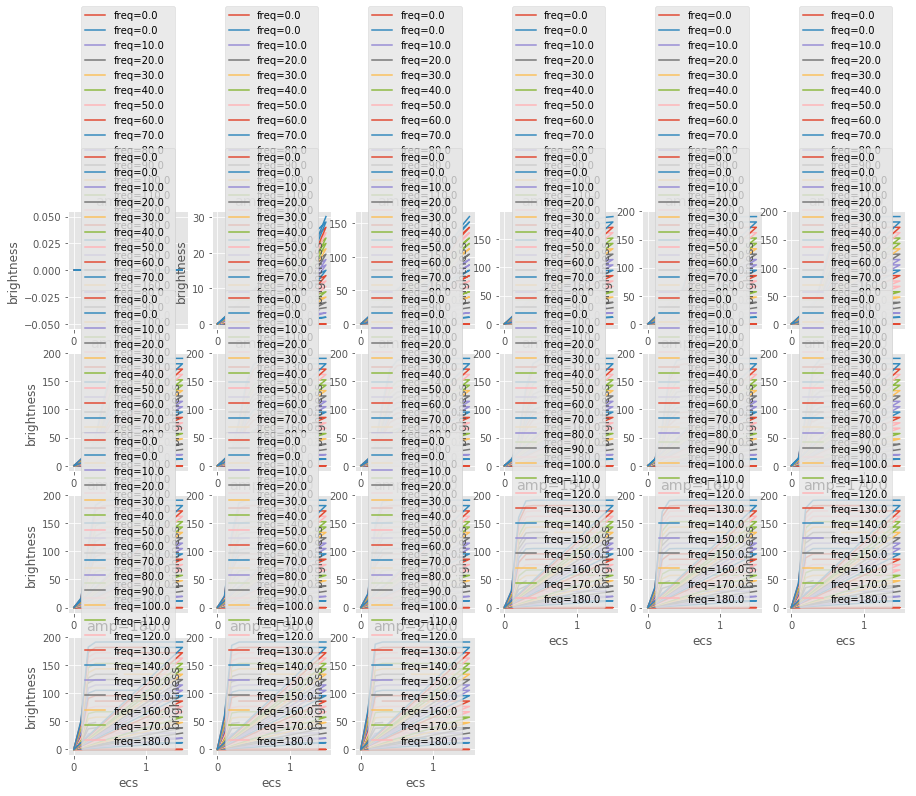

In [14]:
nr = int(np.floor(np.sqrt(len(amps))))
nc = int(np.ceil(len(amps) / nr))
plt.figure(figsize=(15, 10))

na = len(amps)
nf = len(freqs)
ne = len(ecs)
for j in range(na):
    plt.subplot(nr, nc , j + 1)
    in_slice = in_arr[j*nf*ne:(j+1)*nf*ne, :]
    out_slice = out_arr[j*nf*ne:(j+1)*nf*ne]
    for i in range(nf):
        label = 'freq=%.1f' % in_slice[i*15, 1]
        plt.plot(in_slice[i*nf:(i+1)*nf, -1], out_slice[i*nf:(i+1)*nf], label=label)
    plt.xlabel('ecs')
    plt.ylabel('brightness')
    plt.title('amp=%.1f' % amps[j])
    plt.legend()

In [15]:
from scipy.interpolate import RegularGridInterpolator

In [16]:
tm = RegularGridInterpolator((amps, freqs, ecs), out_arr.reshape((len(amps), len(freqs), len(ecs))))

In [17]:
# Verify interpolation
idx = 0
for a in amps:
    for f in freqs:
        for e in ecs:
            if not np.isclose(tm([a, f, e]), out_arr[idx]):
                print('%d: %f != %f' % (idx, tm([a, f, e]), out_arr[idx]))
            idx += 1

In [18]:
# Example usage: 25uA, 10Hz, 0.2ecs
tm([25, 10, 0.2])

array([ 0.2460982])

In [19]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

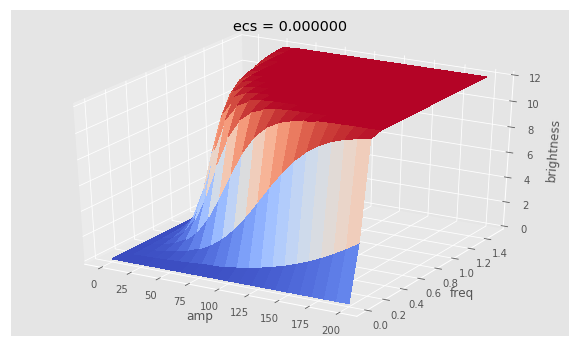

In [20]:
x,y = np.meshgrid(amps, ecs)
z = tm((x, freqs[1], y))

fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel('amp')
ax.set_ylabel('freq')
ax.set_zlabel('brightness')
ax.set_title('ecs = %f' % ecs[0])